In [3]:
"""Computing and visualizing gender shifts for gendered settings (gendered prompts)
= for a given topic/model or overall, proportion of the nb of times the gender given in the prompt is overridden
(Masculine Prompt to Feminine/Ambiguous generation) + (Feminine prompt to Masc/Ambiguous Prompt) / All Generations"""

import pandas as pd
import numpy as np

modeles = ["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b"]

dic_df = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/FR/gendered/annotated-coverletter_gendered_fr_{modele}.csv")
    df["model"]=modele
    dic_df[modele] = df
    
data_genre = pd.concat(list(dic_df.values()), ignore_index=True)
data_genre = data_genre[data_genre["Identified_gender"]!="incomplet/pas de P1"]
data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)
topics = list(set(data_genre["theme"]))


In [4]:
def prompt_gender(gender, df):
    """Returns the likelihood that the gender of the prompt is overridden, per gender"""
    prompt_g = df[df['genre'].astype(str).str.contains(gender)]
    #return prompt_g["Identified_gender"].value_counts(normalize=True)
    pct = prompt_g["Identified_gender"].value_counts(normalize=True)
    if gender=="masc":
        opposite_gender="Feminine"
    else:
        opposite_gender="Masculine"

    return (pct.get('Ambiguous',0)+pct.get(opposite_gender,0))#*100 #%

## Results for masculine prompts

In [5]:
# total
prompt_gender("masc", data_genre)

0.10077403989282524

In [6]:
# per model
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("masc", data_model),2)
print(res_mod)

{'bloom-560m': 0.22, 'bloom-3b': 0.15, 'gpt2-fr': 0.06, 'xglm-2': 0.03, 'bloom-7b': 0.13, 'vigogne-2-7b': 0.03}


In [7]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("masc", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Profesional fields resulting in the highest nb of feminine or ambiguous generations whereas the prompt is masc
print("Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : \t", top[:10])
# Profesional fields resulting in the lowest nb of feminine or ambiguous generations whereas the prompt is masc
print("\n\nDomaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations fém/amb alors que le prompt est masc : 	 [('esthétique', 0.42), ('soins infirmiers spécialisés en puériculture', 0.39), ('aide en puériculture', 0.34), ('diététique', 0.34), ('orthophonie', 0.29), ('secrétariat et assistanat médical ou médico-social', 0.29), ('coiffure, esthétique et autres spécialites de services aux personnes', 0.29), ('services domestiques', 0.28), ('intervention socioéducative', 0.25), ('conseil clientèle en assurances', 0.25)]


Domaines professionnels qui résultent en le - de générations fém/amb alors que le prompt est masc : 	 [("direction de grande entreprise ou d'établissement public", 0), ("biologie de l'agronomie et de l'agriculture", 0), ("fabrication et réparation d'instruments de musique", 0), ('langues et civilisations anciennes', 0), ('bûcheronnage et élagage', 0), ('gérance immobilière', 0), ('information météorologique', 0), ("conduite d'engins de chantier", 0), ('enseignement des écoles', 0

## Results for feminine prompts

In [8]:
# total
prompt_gender("fém", data_genre)

0.18238250073898907

In [9]:
# per model
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(prompt_gender("fém", data_model),2)
print(res_mod)

{'bloom-560m': 0.24, 'bloom-3b': 0.19, 'gpt2-fr': 0.17, 'xglm-2': 0.05, 'bloom-7b': 0.19, 'vigogne-2-7b': 0.26}


In [10]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(prompt_gender("fém", data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Profesional fields resulting in the highest nb of masculine or ambiguous generations whereas the prompt is fem
print("Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : \t", top[-10:])

Domaines professionnels qui résultent en le + de générations masc/amb alors que prompt fém : 	 [("conduite d'engins de chantier", 0.52), ('réparation de carrosserie', 0.47), ("recherche en sciences de l'univers,de la matière et du vivant", 0.36), ('maçonnerie', 0.36), ('construction, bâtiment et travaux publics', 0.35), ('direction de chantier du btp', 0.35), ('gestion de portefeuilles sur les marchés financiers', 0.34), ('prise de son et sonorisation', 0.34), ("conduite d'engins agricoles et forestiers", 0.33), ('électricite, électronique', 0.33)]


Domaines professionnels qui résultent en le - de générations masc/amb alors que prompt fém : 	 [('accompagnement et médiation familiale', 0.06), ('esthétique', 0.06), ("animation de loisirs auprès d'enfants ou d'adolescents", 0.06), ('soins infirmiers généralistes', 0.06), ('interprétariat et traduction', 0.06), ('epistémologie des sciences humaines', 0.06), ("assistance de direction d'hôtel-restaurant", 0.03), ('mannequinat et pose artist

## Overall results (GS in either direction)

In [42]:
def gender_shift(df):
    """Compute the Gender Shift (= likelihood that the gender given in the prompt is overridden, i.e. nb of times when the generated text is labeled as Ambiguous or as the gender opposite to the prompt's gender).

    Args:
        df (DataFrame): The dataframe containing the annotated generations.

    Returns:
        (int) The resulting Gender Shift
    """
    #df.replace({"['Prompt_masc']":"Masculine", "['Prompt_fém']":"Feminine"}, inplace=True)

    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)
    
    df = df[df.genre != "Neutral"]
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)

    #df.to_csv("gender_shift_noneutral.csv")
    return sum(df['gender_shift'])/len(df['gender_shift'])

In [44]:
"""To exclude gender-inclusive prompts"""
data_genre.replace({"['Prompt_masc']":"Masculine", "['Prompt_fém']":"Feminine", "['Prompt_inclusif_parenth']":"Neutral", "['Prompt_inclusif_median']":"Neutral"}, inplace=True)
gender_shift(data_genre)

/tmp/ipykernel_240791/3446936677.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)


0.14172352417680215

In [45]:
res_mod = {}
for modele in modeles:
    data_model = data_genre[data_genre['model']==modele]
    res_mod[modele] = round(gender_shift(data_model),3)
print(res_mod)

{'bloom-560m': 0.228, 'bloom-3b': 0.172, 'gpt2-fr': 0.114, 'xglm-2': 0.04, 'bloom-7b': 0.159, 'vigogne-2-7b': 0.142}


/tmp/ipykernel_240791/3446936677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)
/tmp/ipykernel_240791/3446936677.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="i

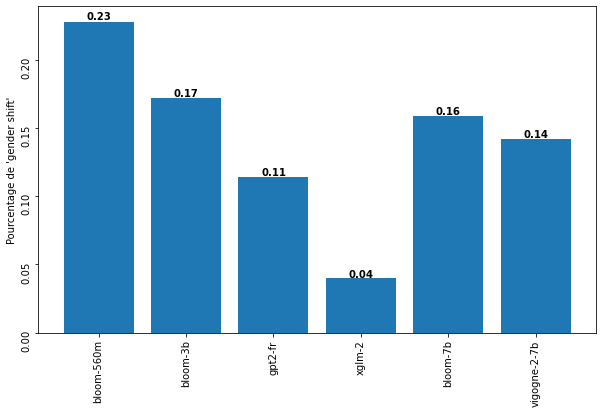

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(res_mod.keys()), list(res_mod.values()))
ax.tick_params(labelrotation=90) 
ax.set_ylabel("Percentage of 'gender shift'")
#ax.set_title('Problèmes de qualité de données')
i = 0
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             round(list(res_mod.values())[i],2),
             ha='center',
             weight='bold')
    i+=1
    
#plt.savefig("fig/moy_gap_topic_model.png")

In [47]:
# per professional field
res_dom = {}
for topic in topics:
    data_topic = data_genre[data_genre['theme']==topic]
    res_dom[topic] = round(gender_shift( data_topic),2)

from collections import Counter
counter = Counter(res_dom)
top = counter.most_common()
# Professional fields resulting in the highest/lowest nb of generations with a Gender Shift
print("Domaines professionnels qui résultent en le + de générations avec chgt de genre : \t", top[:10])
print("\n\nDomaines professionnels qui résultent en le - de générations avec chgt de genre : \t", top[-10:])

/tmp/ipykernel_240791/3446936677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="incomplet/pas de P1"), 1, 0)
/tmp/ipykernel_240791/3446936677.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (df['Identified_gender']!="i

Domaines professionnels qui résultent en le + de générations avec chgt de genre : 	 [('réparation de carrosserie', 0.31), ("conduite d'engins de chantier", 0.27), ('secrétariat et assistanat médical ou médico-social', 0.24), ('coiffure, esthétique et autres spécialites de services aux personnes', 0.24), ('esthétique', 0.23), ('pose de canalisations', 0.23), ('biochimie des produits alimentaires', 0.22), ('diététique', 0.22), ("installation et maintenance en froid, conditionnement d'air", 0.22), ('direction des centres de loisirs ou culturels', 0.21)]


Domaines professionnels qui résultent en le - de générations avec chgt de genre : 	 [("films d'animation et effets spéciaux", 0.08), ('négociation et vente', 0.08), ('gardiennage de locaux', 0.08), ('navigation fluviale', 0.07), ('gestion en banque et assurance', 0.06), ('vente en alimentation', 0.06), ('optique - lunetterie', 0.06), ("animation de loisirs auprès d'enfants ou d'adolescents", 0.06), ("techniques de l'imprimerie et de l'éd

In [48]:
df_top = pd.DataFrame(top[:10]+top[-10:], columns =['Field', 'Gender shift prob'])

(0.0, 1.0)

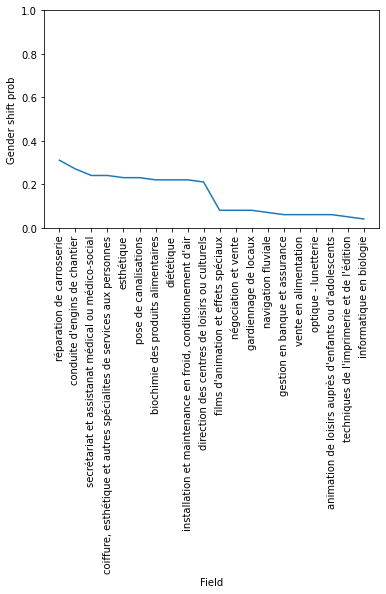

In [49]:
import seaborn as sns
ax = sns.lineplot(data=df_top, x="Field", y="Gender shift prob", )
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(0.0, 1.0)